# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [60]:
# Python Standard Library
# -----------------------
pass

In [61]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [62]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [63]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [64]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [65]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [66]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [67]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

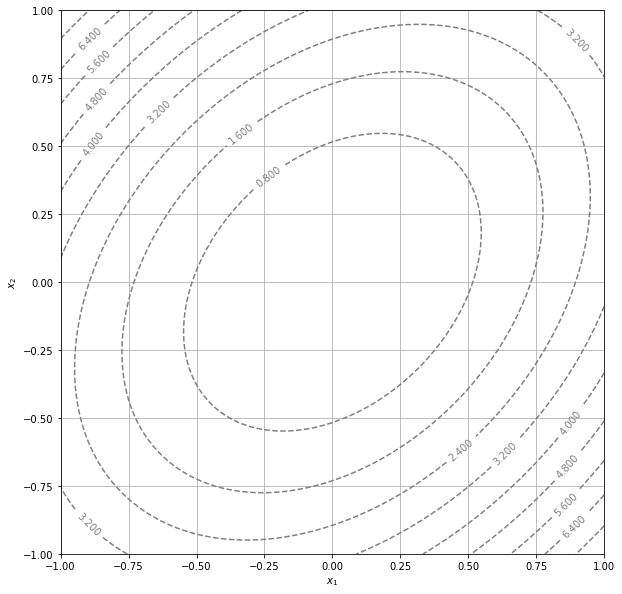

In [68]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [69]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

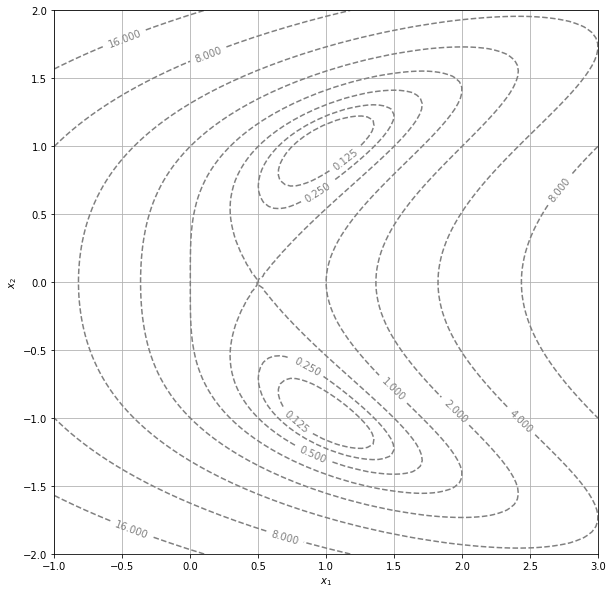

In [70]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [71]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

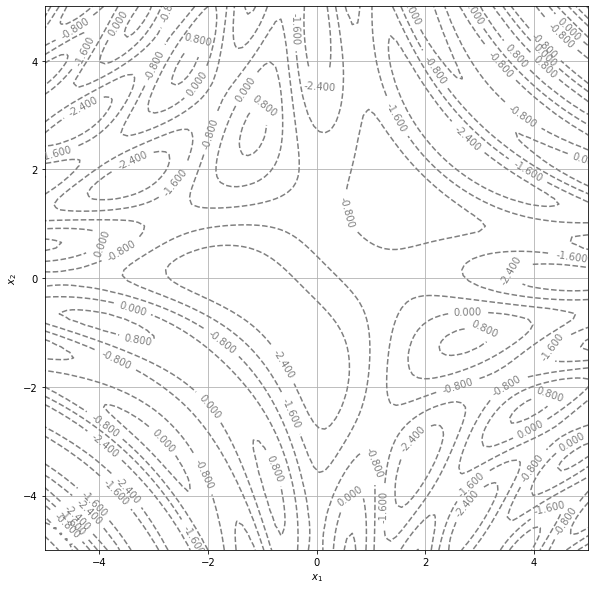

In [72]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Il est borné. En effet par la définition de la limite infinie $ \forall c \in \mathbb{R} , \  \exists A \in \mathbb{R+} $tel que $  \|(x_1,x_2)\| >=  A \implies f(x_1,x_2)>c    \\ $
De plus il est fermé comme image réciproque par $ f $, une fonction continue du fermé $ \{c\}$

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?


$ p(x_1,x_2)= \begin{vmatrix} (x_1 - x_{10}) & {\partial_1 f(x_0)} \over {|| \nabla f(x_0)||} \\ (x_2 - x_{20}) & {\partial_2 f(x_0)} \over {|| \nabla f(x_0)||} \end{vmatrix} $


C'est le determinant entre un vecteur X, déplacement quelconque par rapport à $ \begin{pmatrix} x_0 \\ y_0 \end{pmatrix}$ et $ \nabla f $, $ \forall \epsilon \exists V $ voisinage  de $x_0 $ tq $ p(x_1,x_2) $ maximal a $ ||(x_1,x_2)||=cte ) \iff d(x,ligne \ de \ niveau \ c) \leq \epsilon $.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.


On pose $ g : \begin{matrix} \mathbb{R}^2  \times \mathbb{R} & \to & \mathbb{R}^2 \\ (x_1,x_2,t) & \mapsto & (f(x_1,x_2)-c \ ,p(x_1,x_2)-t) \end{matrix}  $

On a $g((x_{10},x_{20}),0) = (0,0)$

De plus en $((x_{10},x_{20}),0)$ $g$ est continuement différentiable, par règle de la chaîne, continue différentiabilité de $f$ et caractère polynomial de $p$.

De plus $\begin{vmatrix} J_f(x_1,x_2) \end{vmatrix} \ne 0$

Donc le Théorème des Fonctions Implicites nous permet d'affirmer qu'il existe un voisinage $]-\epsilon ; \epsilon [$ de zéro tel que $$\exists \gamma : \begin{matrix} ]-\epsilon; \epsilon [  && \to && \mathbb{R}^2 \\ t && \mapsto && \gamma (t) \end{matrix} \ | \ \forall t \in ]-\epsilon ; \epsilon [ \ , \ (x_1,x_2)=\gamma(t) \iff g((x_1,x_2),t)=(0,0) $$

De plus si $ g((x_1,x_2),t)=(0,0) $ on a $ p(x_1,x_2)=t $ (partie "droite" de $g((x_1,x_2),t))$ ).

Donc on trouve bien : 

$$  \exists \gamma : \ ]-\epsilon; \epsilon [  \to \mathbb{R}^2 \ | \ \forall t \in ]-\epsilon ; \epsilon [ \ , \ (x_1,x_2)=\gamma(t) \iff g((x_1,x_2),t)=(0,0) \iff \left \{ \begin{array}{c} f(x_1,x_2) & = & c \\ p(x_1,x_2) & = & t \end{array} \right . $$

Donc $\gamma(t)=(x_1,x_2)$ où $ t=p(x_1,x_2) \implies g((x_1,x_2),t)=(0,0) \implies f(x_1,x_2)=c$

Et si $f(x_1,x_2)=c$ on a alors  $g((x_1,x_2),p(x_1,x_2))=(0,0)$ en prenant $ t=p(x_1,x_2)$ et donc $ \gamma(t)=(x_1,x_2)$ où $t=p(x_1,x_2)$

Ainsi on a bien montré que $\exists \epsilon >0 \ , \  \exists \gamma : ]-\epsilon,\epsilon[ \to \mathbb{R}^2$tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c \iff (x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

Soit $t \in \left]-\epsilon,\epsilon \right[$.  
Par le théorème des fonctions implicites, on a :
$$ 
J_{\gamma}(t) = - J_{g}(\gamma(t),t)^{-1} * J_{g}(\gamma(t),t)
$$
D'où, après calcul, en notant
$$
\Delta = \begin{vmatrix} \partial_1 f(\gamma(t)) & \partial_2 f(\gamma(t)) \\ {\partial_2 f(x_{0})} \over {|| \nabla f(x_0)||} & - {\partial_1 f(x_{0})} \over {|| \nabla f(x_0)||} \end{vmatrix}
$$
qui est bien non nul sur les points considérés.  

On obtient :
$$
J_{\gamma}(t) = \frac{1}{\Delta}  \begin{bmatrix} \partial_2 f(\gamma(t)) \\ - \partial_1 f(\gamma(t)) \end{bmatrix}
$$
Donc on a l'équivalence suivante:
$$
\gamma'(t) = 0 \iff \nabla f(\gamma(t)) = 0
$$
ce qui montre le premier point par hypothèse sur le gradient de $f$.  
Par ailleurs, en réutilisant l'expression de la jacobienne de $\gamma$, on voit que (pour le produit scalaire euclidien dans $\mathbb{R}^2$)
$$
\langle \gamma'(t) | \nabla f(\gamma(t)) \rangle = 0
$$
et ainsi on a demontre le second point.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [73]:
N = 100

#L'ordre de grandeur est empirique, pour des fonctions qui ne "varient pas trop" on peut prendre :
eps = 10**-2
#on pourrait prendre n'imorte quelle valeur de eps plus gande que le eps machine mais cela ne ferait que augmenter le temps d'execution, c'est inutile dans notre cas où 10**-2 est suffisant

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

Newton "classique" : on utilise le DL1 : $ f(x+h)=f(x)+f'(x)h+o(h)$ on fait donc l'approximation linéaire de f et on trouve qu'alors il y a annulation en $ h= {  {-f(x)} \over {f'(x)}}$

Ici on fait pareil mais avec un DL d'ordre supérieur : $f(x+h)=f(x) + J_f(x) h + o(||h||)$ ce qui amène, en faisant une approximation linéaire et en supposant $J_f(x)$ inversible à f s'annulant pour $h={- J_f(x)^{-1} . f(x) }$

In [74]:
N=100
eps=10**-2

def Newton(F, x0, y0, eps=eps, N=N):
    """Calcule une approximation du point d'annulation de F fonction de R² -> R², à eps près, grâce à la methode de Newton en partant de x0,y0 et en effectuant moins de N étapes"""
    J_f=J(F) #fonction Jacobienne
    for i in range(N):
        val=F(x0,y0)
        Jac=J_f(x0,y0)
        H=-np.linalg.inv(Jac).dot(val)
        x,y=x0+H[0],y0+H[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    raise ValueError(f"no convergence in {N} steps.")




#### Tâche 2
Testez votre implémentation de la fonction `Newton` !
On suggère par exemple de l'utiliser pour chercher un point $ (x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2 $ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [75]:
def ftest(x,y):
    return(np.array([f1(x,y)-0.8,x-y]))

Newton(ftest, 0.8,0.8)

(0.447250250297228, 0.447250250297228)

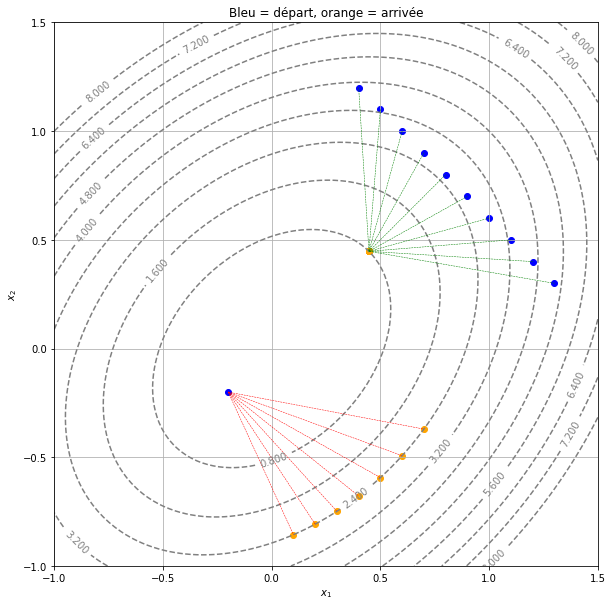

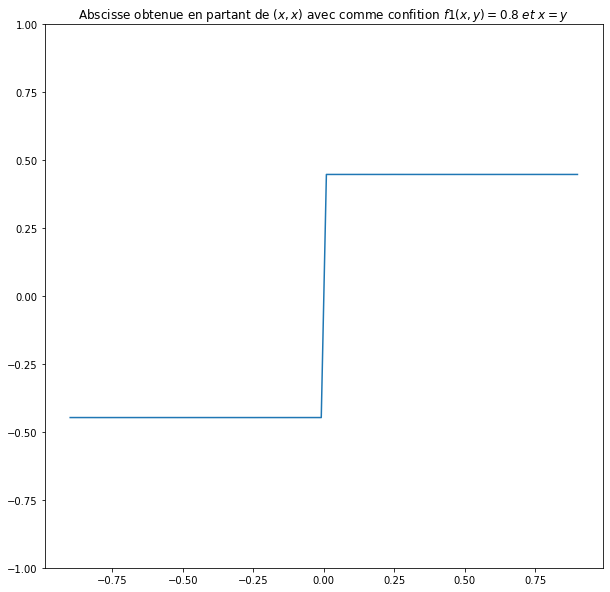

In [76]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.5, 100), 
    y=np.linspace(-1.0, 1.5, 100), 
    levels=[0.8,1.6,2.4,3.2,4.0,4.8,5.6,6.4,7.2,8.0]
)

plt.title("Bleu = départ, orange = arrivée")

def F(x,y):
        return np.array([f1(x,y) - 0.8, x - y])
# on fait varier le point de départ pour le meme point attendu a l 'arrivée : tracé VERT
for i in range(-5,5):
    x, y = Newton(F,0.8-i*0.1,0.8+i*0.1)
    plt.scatter((x),(y), color = 'orange')
    plt.scatter((0.8-i*0.1), (0.8+i*0.1), color = 'blue')
    plt.plot((0.8-i*0.1,x), (0.8+i*0.1, y), color = "green", linestyle = 'dashed', linewidth = 0.5)

# on part du meme point mais on change la deuxieme condition : tracé ROUGE
plt.scatter((-0.2),(-0.2), color = 'blue')
for i in range(1,8):
    def F(x,y):
        return np.array([f1(x,y) - 2.4, x - i*0.1])
    x, y = Newton(F,-0.2,-0.2)
    plt.scatter((x),(y), color = 'orange')
    plt.plot((-0.2,x), (-0.2, y), color = "red", linestyle = 'dashed', linewidth = 0.5)

plt.show()

#mise en évidence du phénomène de points attracteurs
L=np.linspace(-0.9,0.9,100)
F=np.zeros(L.size,dtype='float')
for i in range(L.size):
    F[i]=Newton(ftest,L[i],L[i])[0]
plt.figure()

plt.title("Abscisse obtenue en partant de $(x,x)$ avec comme confition $f1(x,y)=0.8 \ et \ x=y$" )
plt.ylim(-1,1)
plt.plot(L,F)


On remarque qu'il y a des sauts lorsqu'on change de zone attractive.

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

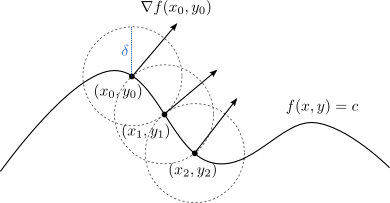

On part d'un point (qui nous fixe la valeur de la courbe de niveau).

Pour passer au point suivant (noté $P_{n+1}$), on calcule $\nabla f$ en $P_n$. On lui applique une rotation de $\pi \over 2$ et on le renornalise à la longueur $\delta$. On applique cette translation à $P_n$ pour trouver un point intermédiaire $P'_n$. Ensuite on lance une méthode de Newton en partant de $P'_n$, il va "glisser" vers la courbe de niveau (avec la condition fixée dans la fonction $g$, $x=y$ dans certains de nos exemples) pour nous en donner une approximation du point suivant $P_{n+1}$.

On réitère cette méthode un nombre de fois prédéfini $N$.


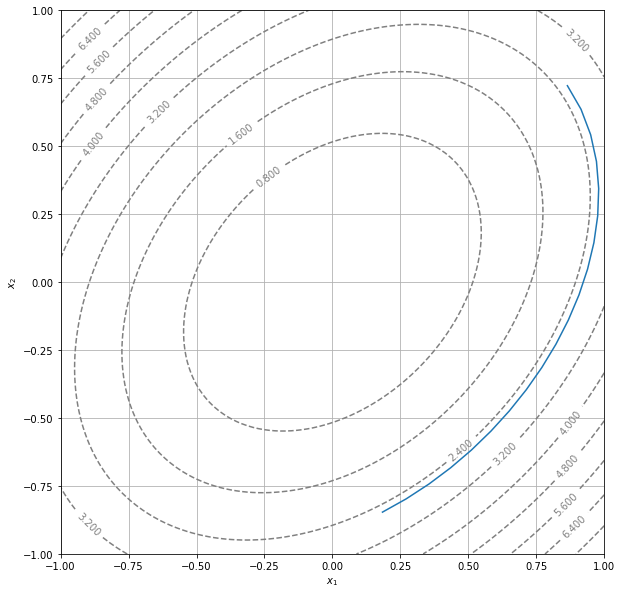

In [77]:
Nnew=100 #paramètrre de l'algo de Newton
eps=10**-2


def determine_suivant(f, x, y, delta):
   """cherche le déplacement optimal pour se rapprocher du point suivant, dans l'hypothèse d'une fonction suffisament 'lisse' pour être approximée par une fonction linéaire. On cherche le vecteur n orthogonal au gradient et à sa droite : n.grad_f = 0 et |n,grad_f|>0 (formule inspirée par la fonction p). """
   d1f,d2f=grad(f)(x,y)
   n1,n2=d2f,-d1f #rotation de pi/2
   deplacement=np.array([n1,n2])*delta/np.sqrt(n1**2 + n2**2) #on normalise pour se deplacer de delta
   return x+deplacement[0],y+deplacement[1]


def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
   c=f(x0,y0)

   def F(x,y):
      return(np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta*delta]))

   courbe = np.zeros((2,N))

   for i in range(N):
      x1,y1=determine_suivant(f,x0,y0,delta) #on se rapproche du suivant "tout droit"
      x,y=Newton(F,x1,y1,eps,Nnew) #on laisse le point se faire aspirer vers la ligne de niveau
      courbe[:,i]=x,y
      x0,y0=x,y
   return courbe

# print(courbe)
courbe = level_curve(f1,0.8,0.8,delta=10**-1,N=20)

abscisses = courbe[0,:]
ordonnees = courbe[1,:]

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.plot(abscisses,ordonnees)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

Prenons l'exemple de la fonction de Rosenbrock : seule la courbe de niveau 0.5 s'intersecte. Toutes les autres étant des courbes de niveau non auto-intersectantes.

D'une manière génarale, une courbe auto-intersectante fait que les courbes adjacentes ne peuvent pas l'être autour de l'interséction. Car la fonction est continuement différentiable et deux lignes de niveau différents ne peuvent pas s'intersecter.
Donc les points d'auto-intersection (et les courbes qui vont avec) sont extrêmement rares (dénombrables).

In [78]:
Nnew=100 #paramètrre de l'algo de Newton
eps=10**-2
import autograd.numpy as np


def se_croisent(xa,ya,xb,yb,xc,yc,xd,yd):
    "calcule les 4 déerminants pour voir si les segments AB et CD se croisent"
    det1=(xd-xc)*(ya-yc)-(yd-yc)*(xa-xc)
    det2=(xd-xc)*(yb-yc)-(yd-yc)*(xb-xc)
    det3=(xb-xa)*(yd-ya)-(yb-ya)*(xd-xa)
    det4=(xb-xa)*(yc-ya)-(yb-ya)*(xc-xa)

    return det1*det2<0 and det3*det4<0
        

def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
   c=f(x0,y0)
   grad_f=grad(f)
   def F(x,y):
      return(np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta*delta]))

   courbe = [[x0,y0]]

   for i in range(N):
      x1,y1=determine_suivant(f,x0,y0,delta) #on se rapproche du suivant "tout droit"
      x,y=Newton(F,x1,y1,eps,Nnew) #on laisse le point se glisser vers la ligne de niveau
      courbe.append([x,y])
      if se_croisent(courbe[0][0],courbe[0][1],courbe[1][0],courbe[1][1],x,y,courbe[-2][0],courbe[-2][1]):
          print(f"Arret : on a recroisé le premier segment au bout de {i} étapes")
          return np.array(courbe).transpose()  
      x0,y0=x,y

   return np.array(courbe).transpose()



#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

Arret : on a recroisé le premier segment au bout de 34 étapes


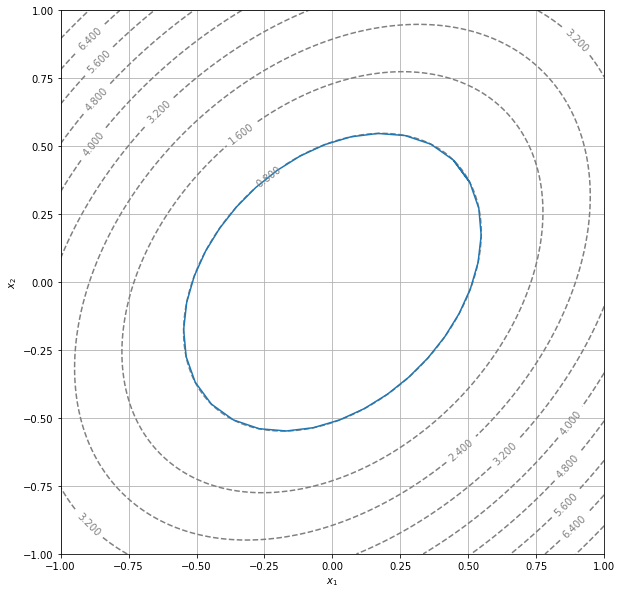

In [83]:

#k permet de choisir parmi les differentes fonctions celle dont on veut executer la démo

k=2

if k==1:
    courbe = level_curve(f1,0.447,0.447,delta=10**-1,N=200)
    display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
    )

if k==2:
    display_contour(
        f2, 
        x=np.linspace(-1.0, 3.0, 100), 
        y=np.linspace(-2.0, 2.0, 100), 
        levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
    )
    courbe = level_curve(f2,1.,0.,delta=10**-2,N=1000)

if k==3:
    display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
    )
    courbe = level_curve(f3,1.25,0.25,delta=5*10**-2,N=500)


abscisses = courbe[0,:]
ordonnees = courbe[1,:]

plt.plot(abscisses,ordonnees)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

On reprend les notations de l'énoncé.  
On a alors en explpoitant les conditions sur $\gamma$ et sa dérivée en 1 et 0
$$
\left\{
    \begin{array}{ll}
        a = p_{11} \\
        d = p_{12} \\
        a + b + c = p_{21} \\
        d + e + f = p_{22} \\
        b = \lambda_1u_{11} \\
        e = \lambda_1u_{12} \\
        b + 2c = \lambda_2u_{21} \\
        e + 2f = \lambda_2u_{22}
    \end{array}
\right.
$$

 où $\lambda_1$ et $\lambda_2$ sont des constantes positives dépendantes du système.

On obtient les résultats suivant :  
    Si $u_{22}*u_{11} - u_{12}*u_{21} \neq 0$ et $b \neq 0$ alors on a les solutions suivantes:  
$$
\left\{
    \begin{array}{ll}
        a = p_{11} \\
        d = p_{12} \\
        \lambda_2 = 2*\frac{(u_{11}*(p_{22}-p_{12})-u_{12}*(p_{21}-p_{11}))}{(u_{22}*u_{11}-u_{12}*u_{21})} \\
        \lambda1 = \frac{u_{11}}{b} \\
        b = 2*(p_{21}-p_{11}-u_{21}*\lambda_2/2) \\
        c = p_{21} - p_{11} - b \\
        e = 2*(p_{22}-p_{12}-u_{22}*\lambda_2/2) \\
        f = p_{22} - p_{12} - e \\
    \end{array}
\right.
$$
Si $u_{22}*u_{11} - u_{12}*u_{21} \neq 0$ et $b = 0$ alors on a les mêmes solutions que précédemment sauf $\lambda1$ qui peut prendre la valeur que l'on souhaite et on choisira arbitrairement $\lambda_2$, ce qui n'influe pas sur la possibilite de repondre au probleme. 

In fine, si  $u_{22}*u_{11} - u_{12}*u_{21} \neq 0$ alors il existe une solution et $\lambda_1$ et $\lambda_2$ sont positifs  si et seulement si on repond au critere de la question.  

Si $u_{22}*u_{11} - u_{12}*u_{21} = 0$ alors les vecteurs $u_1$ et $u_2$ sont colinéaires et le systeme n'a de solution que si $P_1$ et $P_2$ sont sur la meme abscisse ou ordonnée et les relier par une parabole revient à les relier par un segment d'où ce cas n'est pas à traiter.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




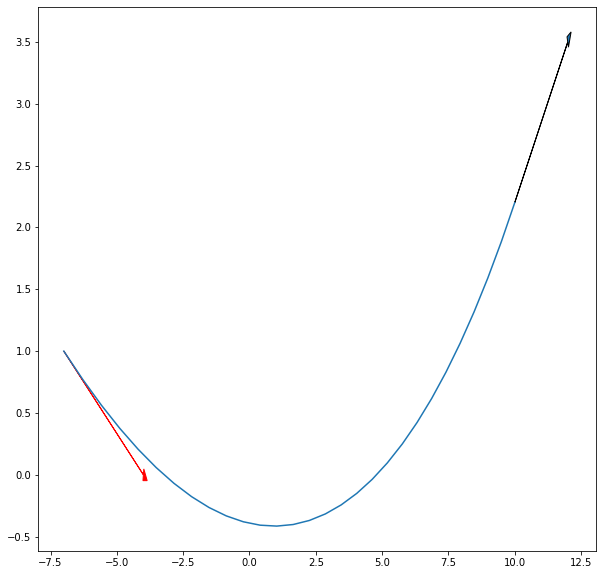

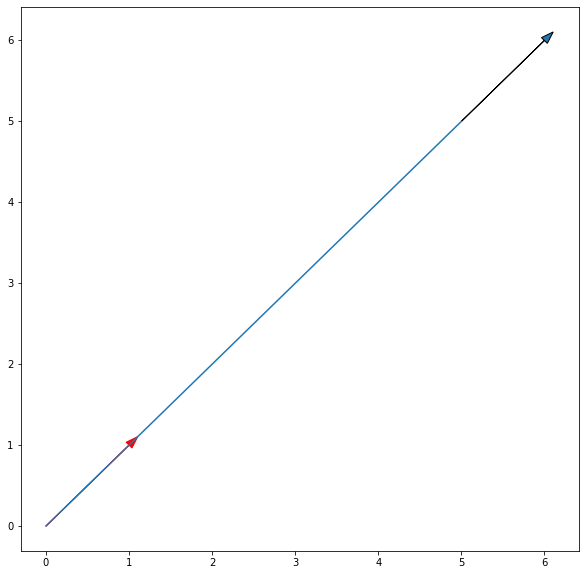

In [80]:
##### import numpy as np
import matplotlib.pyplot as plt

def gamma(t,P1,P2,u1,u2):
    (p11, p12), (p21, p22) = P1, P2
    (u11, u12), (u21, u22) = u1, u2
    
    if u22*u11 - u12*u21 == 0:
        return (p21-p11)*t + p11, (p22-p12)*t +p12
    
    lambda2 = 2*(u11*(p22-p12)-u12*(p21-p11))/(u22*u11-u12*u21)
    if u11 !=0:
        lambda1=(2*(p21-p11)-lambda2*u21 )/u11
    elif u12 !=0:
        lambda1=(2*(p22-p12)-lambda2*u22 )/u12
    else :
        lambda1=1 #U1=0 donc on arrive comme on veut sur le point, on fixe lambda1>0 (la valeur ne sert pas)
        
    if lambda2>=0 and lambda1>=0:
        a = p11
        b = 2*(p21-p11-u21*lambda2/2)
        c = p21 - p11 - b
        d = p12
        e = 2*(p22-p12-u22*lambda2/2)
        f = p22 - p12 - e
        return a + b*t + c*t**2, d + e*t + f*t**2
    else :
        return (p21-p11)*t + p11, (p22-p12)*t +p12
        
    
    
    
def affiche_gamma(P1,P2,u1,u2, oversampling=1):
    def gamma_bis(t):
        return gamma(t, P1,P2,u1,u2)
    t = np.linspace(0,1,oversampling-1)
    y = np.array(gamma_bis(t))
    plt.plot(y[0,:],y[1,:])
    plt.arrow(P1[0],P1[1],u1[0],u1[1],head_width=0.1,color='r')
    plt.arrow(P2[0],P2[1],u2[0],u2[1],head_width=0.1)
    plt.show()

plt.figure()
affiche_gamma((-7.,1.),(10.,2.2), (3.,-1.), (2.,1.3), 30)
affiche_gamma((0.,0.),(5.,5.), (1.,1.), (1.,1.), 30)

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [114]:
Nnew=100 #paramètre de l'algo de Newton
eps=10**-2

def se_croisent(xa,ya,xb,yb,xc,yc,xd,yd):
    "calcule les 4 déerminants pour voir si les segments AB et CD se croisent"
    det1=(xd-xc)*(ya-yc)-(yd-yc)*(xa-xc)
    det2=(xd-xc)*(yb-yc)-(yd-yc)*(xb-xc)
    det3=(xb-xa)*(yd-ya)-(yb-ya)*(xd-xa)
    det4=(xb-xa)*(yc-ya)-(yb-ya)*(xc-xa)

    return det1*det2<0 and det3*det4<0
       
def level_curve_final(f, x0, y0, delta=0.1, N=100, eps=eps, oversampling = 1):
   '''
   Construit une courbe de niveau en ajoutant si possible oversampling - 1 points entre deux points calculés par la méthode de Newton grace à la fonction gamma 
   '''
   c=f(x0,y0)
   grad_f=grad(f)
   marqueur  = 0 # indique la position de remplissage de courbe, on ne sait pas a l avance si on pourra appliquer la methode de la fonction gamma a chaque fois 
   courbe = np.zeros((2,N*(oversampling)+1)) # cas ou on peut appliquer gamma a chaque fois donne ce nombre maximal
   courbe[0][0], courbe[1][0] = x0, y0
   t = np.linspace(0,1, oversampling + 1)
   tableau = np.array([])

   def F(x,y):
      return(np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta*delta]))
      
   for i in range(N):
      x1,y1=determine_suivant(f,x0,y0,delta) #on se rapproche du suivant "tout droit"
      x,y=Newton(F,x1,y1,eps,Nnew) #on laisse le point se glisser vers la ligne de niveau
      
      (u11, u12), (u21, u22) = grad_f(x0,y0), grad_f(x,y)

      tableau = gamma_vec(t, (x0, y0), (x, y), (u12, -u11), (u22, -u21))
                 
      for rang in range(0,oversampling-1): # on ajoute les points de la fonction gamma
         courbe[0][marqueur + rang] = tableau[0][rang]
         courbe[1][marqueur + rang] = tableau[1][rang]
      marqueur += oversampling - 1
            
      if se_croisent(courbe[0][0],courbe[0][oversampling],courbe[1][0],courbe[1][oversampling],x,y,courbe[0][marqueur - oversampling + 1],courbe[1][marqueur - oversampling + 1]):
         print(f"Arret : on a recroisé le premier segment au bout de {i} étapes")
         return courbe[:,:marqueur]  
      x0,y0=x,y
   return courbe[:,:marqueur]

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

Arret : on a recroisé le premier segment au bout de 11 étapes
Arret : on a recroisé le premier segment au bout de 11 étapes


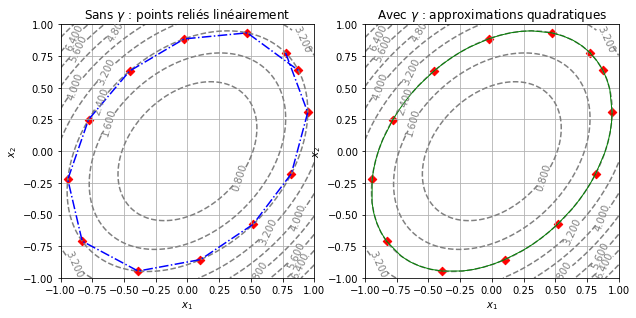

In [141]:
def display_contour2(f, x, y, levels):
    """fonction display_contour modifiée pour pouvoir faire des subplots"""
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

plt.figure()
plt.subplot(1,2,1)
plt.title("Sans $\gamma$ : points reliés linéairement")

display_contour2(
f1, 
x=np.linspace(-1.0, 1.0, 100), 
y=np.linspace(-1.0, 1.0, 100), 
levels=10 # 10 levels, automatically selected
)
courbe_bis = level_curve(f1,0.7745,0.7745, N=15, delta=5*10**-1)
plt.plot(courbe_bis[0,:], courbe_bis[1,:],'b-.')
plt.scatter(courbe_bis[0,:], courbe_bis[1,:],marker='D',color='r')

plt.subplot(1,2,2)
plt.title("Avec $\gamma$ : approximations quadratiques")

display_contour2(
f1, 
x=np.linspace(-1.0, 1.0, 100), 
y=np.linspace(-1.0, 1.0, 100), 
levels=10 # 10 levels, automatically selected
)
courbe = level_curve_final(f1,0.7745,0.7745,delta=5*10**-1,N=15, oversampling = 6)
abscisses = courbe[0,:]
ordonnees = courbe[1,:]
plt.plot(abscisses,ordonnees,'g',linewidth=1)
plt.scatter(courbe_bis[0,:], courbe_bis[1,:],marker="D",color="r")

plt.show()